### Install Required Packages

We would be running `Stable Diffusion 2` so enable `GPU` under `View Resources > Change runtime type`

In [4]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-cd2b0eba-4b15-fd6b-7c9b-0f1907cd9cfb)


In [5]:
%%capture
!pip install transformers # for CLIPTokenizer
!pip install daam # for Heatmap generation
!pip install accelerate  # this is to reduce CPU model load overhead
!pip install stanza # for stanford pos tagger
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git # for CLIP Re-Ranking
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html

### Load Necessary Libraries

We will load the necessary libraries required for generating DAAM outputs for input prompts.

In [153]:
# General
import os
import json
import datetime
from tqdm import tqdm
import base64
import IPython
import random
import requests
from io import BytesIO
from math import trunc

# Plotting
from matplotlib import pyplot as plt

# Data Handling
import numpy as np
from pycocotools.coco import COCO

# Image Processing
from PIL import Image
from PIL import ImageDraw as PILImageDraw
import cv2

# Language Processing
from transformers import CLIPTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag 

# Image Generation
from diffusers import StableDiffusionImg2ImgPipeline
import daam

# Model
import torch
import clip

Download the stopwords for removing stopwords

In [7]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [8]:
import stanza
stanza.download('en')

INFO:stanza:Downloading default packages for language: en (English) ...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.


### Load Data

The below list is a placeholder for any list of prompts, we will be replacing it with a list of prompts from `MS-COCO` text annotations later.

['Man']


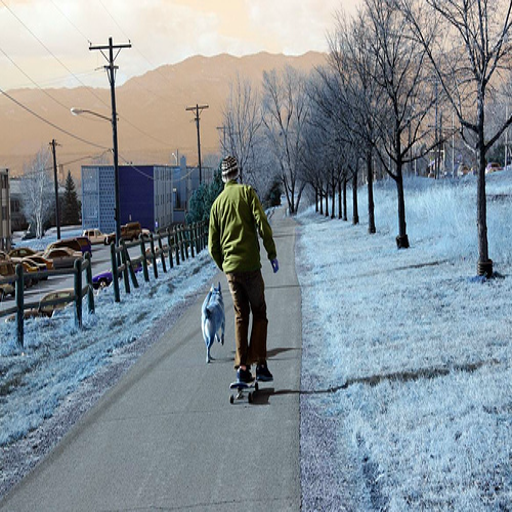

In [72]:
# Objects to detect in the image separated by spaces
prompts = [
  "Man"
]
print(prompts)

# Image
url = "https://miro.medium.com/max/500/0*w1s81z-Q72obhE_z"

response = requests.get(url)
init_img = Image.open(BytesIO(response.content)).convert("RGB")
init_img = init_img.resize((512, 512))
init_img

Cleaning the prompts. I adopt few ways to clean the prompt:
- Lower Case Conversion (Using the tokenizer that comes with the Diffusion Model)
- Tokenization (Using the tokenizer that comes with the Diffusion Model)
- Remove sentences that exceed the Diffusion Model's Allowed Length (No. of Tokens)
- Remove stop words
- Remove non-alphabets
- Keep only nouns
- Lemmatization (to store the object name)
- Discard any lemma/word with non-alphabet characters. (As `LAION` has lots of noise)

NOTE: You can tweak the following parameters in the `stanza.Pipeline` parameter to use varying amount of Memory.
- `pos_batch_size=6500`
- Set the `DIFFUSION_MODEL_PATH` below to use the tokenizer from it to use for tokenization, allows better alignment and prevents error in alignment

In [10]:
DIFFUSION_MODEL_PATH = 'stabilityai/stable-diffusion-2-base' # Set the model path to load the diffusion model from

# loads the CLIPTokenizer with the configuration same as that used in the Diffusion Model
# Using Stanza Tokenizer might generate different tokens compared to the CLIP, leading to misalignment in DAAM - Causing Error
tokenizer = CLIPTokenizer.from_pretrained(DIFFUSION_MODEL_PATH, subfolder="tokenizer")

In [11]:
# loads the text processing pipeline
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma', tokenize_no_ssplit=True, tokenize_pretokenized=True, verbose=True, pos_batch_size=6500)

# treebank-specific POS (XPOS) tags to keep, other POS tagged tokens will not be retained
keep_pos_tags = ['NN', 'NNS', 'NNP', 'NNPS']

# Stopwords
stpwords = set(stopwords.words('english'))

# extract parts of speech
def extract_pos(doc):
  parsed_text = list()
  for sent in doc.sentences:
    parsed_sent = list()
    for wrd in sent.words:
      #extract text and pos
      parsed_sent.append((wrd.text, wrd.xpos))
    parsed_text.append(parsed_sent)
  return parsed_text

# extract lemma
def extract_lemma(doc):
  parsed_text = list()
  for sent in doc.sentences:
    parsed_sent = list()
    for wrd in sent.words:
      # extract text and lemma
      parsed_sent.append((wrd.text, wrd.lemma))
    parsed_text.append(parsed_sent)
  return parsed_text

def clean_prompt(sentences):
  # convert the sentences to lower case and tokenizes the sentences to be passed onto Stanza for POS Tagging
  sentences_lc_tokenized = tokenizer.batch_decode([[word for word in sent[1:-1]] for sent in tokenizer(sentences)['input_ids'] if len(sent) <= tokenizer.model_max_length])

  # stanza accepts only a single string instead of list of strings. So, we have set the tokenize_no_ssplit=True and have to join each sentence with double newline
  sentence_string = "\n\n".join(sentences_lc_tokenized)

  # tokenizes, lemmatizes and pos tags the prompt
  with torch.no_grad():
    processed_prompt = nlp(sentence_string)
  
  # extracts pos tags from the processed_prompt
  pos_tagged_prompt = extract_pos(processed_prompt)

  # lemmatized text
  lemmatized_prompt = extract_lemma(processed_prompt)

  del processed_prompt

  # keep only the noun words, removes stopwords
  fin_prompt = [[word for word, pos_tag in sent if word is not None and ((pos_tag in keep_pos_tags) and (word not in stpwords) and (word.isalpha()))] for sent in pos_tagged_prompt]
  obj_prompt = [[word_lemma[1] for word_pos, word_lemma in zip(sent_pos, sent_lemma) if (word_lemma[0] is not None and word_lemma[1] is not None) and ((word_pos[1] in keep_pos_tags) and ((word_lemma[0] not in stpwords) or (word_lemma[1] not in stpwords)) and word_lemma[0].isalpha() and word_lemma[1].isalpha())] for sent_pos, sent_lemma in zip(pos_tagged_prompt, lemmatized_prompt)]
  
  del pos_tagged_prompt, lemmatized_prompt
  
  return sentences_lc_tokenized, fin_prompt, obj_prompt

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |

INFO:stanza:Use device: gpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


An example is shown below for the application of `clean_prompt`.

In [12]:
clean_prompt(prompts)

(['truck'], [['truck']], [['truck']])

### Setting up the Pipeline

#### Brief Overview of the Storage Scheme of the Generated Data

I will set up the pipeline for generation of the heatmaps and bounding boxes for each generated image for each prompt in the `prompts` list. We will be generating `NUM_IMAGES_PER_PROMPT` images per prompt.

Every output by our code will be stored in `Data-Generated` folder.

I use `COCO` Dataset format to store the bboxes and segmentation for each image.

#### Set some parameters

In [154]:
DEVICE = 'cuda' # device
NUM_IMAGES_PER_PROMPT = 1 # Number of images to be generated per prompt
STRENGTH = 0.3 # The noise to add to original image
NUM_INFERENCE_STEPS = 50 # Number of inference steps to the Diffusion Model
NAME_OF_DATASET = 'COCO Stable Diffusion 2 Dataset' # Name of the generated dataset
SAVE_AFTER_NUM_IMAGES = 1 # Number of images after which the annotation and caption files will be saved
NMS_OVERLAP_THRESHOLD = 0.5 # Non-Max Suppression Threshold
BLUR_KERNEL_SIZE = (5, 5) # The size of the kernel to be used for blurring the heatmap before binary thresholding
PRE_NMS_SMALL_SEGMENT_THRESH = 30 # For filtering small segments, higher the threshold more smaller contours will be allowed (before applying NMS)
PRE_NMS_SMALL_BOX_THRESH = 30 # For filtering small bboxes, higher the threshold more smaller boxes will be allowed (before applying NMS)
SMALL_SEGMENT_THRESH = 30 # For filtering small segments, higher the threshold more smaller segments will be allowed (Within a bbox operation for each category in an image)
SMALL_BOX_THRESH = 30 # For filtering small boxes, higher the threshold more small boxes will be allowed (Between bboxes operation for each category in an image)

Now, let's load the `stabilityai/stable-diffusion-2-base` diffusion model.

In [14]:
model = StableDiffusionImg2ImgPipeline.from_pretrained(DIFFUSION_MODEL_PATH)
model = model.to(DEVICE) # Set it to something else if needed, make sure DAAM supports that

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Setting up the folder structure to generate the data and the dataset information for storing annotations and captions in `COCO` format.

In [168]:
# The folder that will contain the generated data
os.mkdir('Data-Generated') # Stores everything that is generated
os.mkdir('Data-Generated/images') # Stores generated images
os.mkdir('Data-Generated/annotations') # Stores Annotations
os.mkdir('Data-Generated/captions') # Stores Captions

info = { # Info about the dataset
    "description": NAME_OF_DATASET,
    "url": "https://github.com/RishiDarkDevil/Text-Based-Object-Discovery",
    "version": "1.0",
    "year": 2022,
    "contributor": "Rishi Dey Chowdhury (RishiDarkDevil)",
    "date_created": "2022"
}

licenses = [{ # Licenses associated with the dataset
    'url': 'https://huggingface.co/stabilityai/stable-diffusion-2/blob/main/LICENSE-MODEL',
    'id': 1,
    'name': 'CreativeML Open RAIL++-M License'
}]

images = list() # Stores the generated image info
annotations = list() # Stores the annotation info
categories = list() # Stores the category info
captions = list() # Stores the captions info
cat2id = dict() # Stores the category to id mapping
cat_id = 1 # Assigns id to categories as we go on adding categories which we discover
image_id = 1 # Assigns generated image ids
annotation_id = 1 # Assigns annotations annotation ids
caption_id = 1 # Assigns captions caption ids
save_idx = 1 # The index which stores how many times we saved the json file before

Let's generate Global Word Attribution HeatMaps.

In [169]:
class NpEncoder(json.JSONEncoder): # To help encode the unsupported datatypes to json serializable format
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    if isinstance(obj, np.floating):
        return float(obj)
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return json.JSONEncoder.default(self, obj)

def save(): # Saving annotations and captions when called -- mainly to avoid code repetition
  # Serializing json
  json_obj_det = json.dumps({
      'info': info,
      'licenses': licenses,
      'images': images,
      'annotations': annotations,
      'categories': categories
  }, indent=4, cls=NpEncoder)

  # Writing json
  with open(f"Data-Generated/annotations/object_detect-{save_idx}.json", "w") as outfile:
    outfile.write(json_obj_det)

  print('Saved Annotations')

  # Delete json from python env
  del json_obj_det

  # Serializing json
  json_obj_cap = json.dumps({
      'info': info,
      'licenses': licenses,
      'images': images,
      'annotations': captions,
  }, indent=4, cls=NpEncoder)

  # Writing json
  with open(f"Data-Generated/captions/object_caption-{save_idx}.json", "w") as outfile:
    outfile.write(json_obj_cap)

  # Delete json from python env
  del json_obj_cap

  # Clearing out all the lists except cat2id to maintaining the unique category ids assigned to each new object
  images.clear()
  annotations.clear()
  categories.clear()
  captions.clear()

In [170]:
# Helper Function that performs Non-Max Suppression when given the bounding boxes and threshold
# We merge multiple boxes together using Non-Max Suppression with a modification. Since, each box is corresponding to a segment. Now, when we delete boxes, we keep track 
# which box it is merged to. Now, if we use the boundary of this box as a boundary for the object there would be segments spreading out of the box. So, instead I enlarge the 
# box to the extreme segment which merged to this box by NMS 
# Greatly reduces too many bounding boxes.
def non_max_suppression_fast(boxes, overlapThresh):
  # if there are no boxes, return an empty list
  if len(boxes) == 0:
    return []
  # if the bounding boxes integers, convert them to floats --
  # this is important since we'll be doing a bunch of divisions
  if boxes.dtype.kind == "i":
    boxes = boxes.astype("float")
  # initialize the list of picked indexes	
  pick = []
  pick2idx = dict()
  # grab the coordinates of the bounding boxes
  x1 = boxes[:,0]
  y1 = boxes[:,1]
  x2 = boxes[:,2]
  y2 = boxes[:,3]
  # compute the area of the bounding boxes and sort the bounding
  # boxes by the bottom-right y-coordinate of the bounding box
  area = (x2 - x1 + 1) * (y2 - y1 + 1)
  idxs = np.argsort(y2)
  # keep looping while some indexes still remain in the indexes
  # list
  while len(idxs) > 0:
    # grab the last index in the indexes list and add the
    # index value to the list of picked indexes
    last = len(idxs) - 1
    i = idxs[last]
    pick.append(i)
    # find the largest (x, y) coordinates for the start of
    # the bounding box and the smallest (x, y) coordinates
    # for the end of the bounding box
    xx1 = np.maximum(x1[i], x1[idxs[:last]])
    yy1 = np.maximum(y1[i], y1[idxs[:last]])
    xx2 = np.minimum(x2[i], x2[idxs[:last]])
    yy2 = np.minimum(y2[i], y2[idxs[:last]])
    # compute the width and height of the intersection bounding box
    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)
    # compute the ratio of overlap
    overlap = (w * h) / area[idxs[:last]]
    # delete all indexes from the index list that have
    to_delete = np.concatenate(([last], np.where(overlap >= overlapThresh)[0]))
    idxs = np.delete(idxs, to_delete)
    # the boxes to be deleted are mapped to a box so the box to which it is mapped
    # should also be in the dictionary else it will be omitted all together
    pick2idx[i] = list(to_delete) + [i]

  # return only the bounding box idx that were picked
  return pick, pick2idx

# Detects connected components to prevent bounding boxes overlapping each other even after NMS
def getRoots(aNeigh):
  def findRoot(aNode,aRoot):
    while aNode != aRoot[aNode][0]:
      aNode = aRoot[aNode][0]
    return (aNode,aRoot[aNode][1])
  myRoot = {} 
  for myNode in aNeigh.keys():
    myRoot[myNode] = (myNode,0)  
  for myI in aNeigh: 
    for myJ in aNeigh[myI]: 
      (myRoot_myI,myDepthMyI) = findRoot(myI,myRoot) 
      (myRoot_myJ,myDepthMyJ) = findRoot(myJ,myRoot) 
      if myRoot_myI != myRoot_myJ: 
        myMin = myRoot_myI
        myMax = myRoot_myJ 
        if  myDepthMyI > myDepthMyJ: 
          myMin = myRoot_myJ
          myMax = myRoot_myI
        myRoot[myMax] = (myMax,max(myRoot[myMin][1]+1,myRoot[myMax][1]))
        myRoot[myMin] = (myRoot[myMax][0],-1) 
  myToRet = {}
  for myI in aNeigh: 
    if myRoot[myI][0] == myI:
      myToRet[myI] = []
  for myI in aNeigh: 
    myToRet[findRoot(myI,myRoot)[0]].append(myI) 
  return myToRet 

In [171]:
# Cleaning the prompts and storing objects - Updating the prompts with smaller prompts in proper format to feed the model to prevent index errors
prompts, cleaned_prompts, object_prompts = clean_prompt(prompts)

try:
  # Iterating overs the prompts
  for i, prompt in enumerate(prompts):

    cleaned_prompt = cleaned_prompts[i]
    object_prompt = object_prompts[i]
    # Flashing some details
    print()
    print(f'Prompt No. {i+1}/{len(prompts)}')
    print('Prompt:', prompt)
    print('Cleaned Prompt:', ' '.join(cleaned_prompt))
    print('Objects:', ' '.join(object_prompt))
    print('Generating Image...')

    try:
      # Stores the new objects found in this prompt
      new_words = list()
      # Updating Categories using cleaned prompt if required and assigning index
      for ind, word in enumerate(object_prompt):
        if word not in cat2id:
          new_words.append(word)
          cat2id[word] = cat_id
          categories.append({"supercategory": '', "id": cat_id, "name": word}) ### FIX SUPERCATEGORY
          cat_id += 1

      for j in range(NUM_IMAGES_PER_PROMPT):

        # Generating images and storing their trace for daam output
        with daam.trace(model) as trc:
          output_image = model(prompt=prompt, init_image=init_img, strength=STRENGTH, guidance_scale=7.5).images[0]
          global_heat_map = trc.compute_global_heat_map()

        # Saving generated Image
        output_image.save(f'Data-Generated/images/{i}_{j}.png')
        print(f'Saving generated Image as.. {i}_{j}.png')

        width, height = output_image.size
        # Image details
        image_det = {
            'license': 1,
            'file_name': f'{i}_{j}.png',
            'height': height,
            'width': width,
            'date_captured': datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S"),
            'id': image_id
        }
        images.append(image_det)

        # Captions details
        cap_det = {
            'id': caption_id,
            'image_id': image_id,
            'caption': prompt
        }
        captions.append(cap_det)

        print(f'Generating Annotations for {i}_{j}.png')
        # Generate Global Word Attribution HeatMap
        for word, obj in tqdm(zip(cleaned_prompt, object_prompt)):

          # word category id
          word_cat_id = cat2id[obj]
          
          # Compute heatmap for a non-stopword
          word_heatmap = global_heat_map.compute_word_heat_map(word).expand_as(output_image).numpy()

          # Casting heatmap from 0-1 floating range to 0-255 unsigned 8 bit integer
          heatmap = np.array(word_heatmap * 255, dtype = np.uint8)

          # Blur the heatmap for better thresholding
          blurred_heatmap = cv2.GaussianBlur(heatmap, BLUR_KERNEL_SIZE, 0)

          # Binary threshold of the above heatmap - serves as sort of semantic segmentation for the word
          thresh = cv2.threshold(heatmap, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

          # Find contours from the binary threshold
          cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
          cnts = cnts[0] if len(cnts) == 2 else cnts[1]

          if len(cnts) == 0: # If no contours detected skip
            continue
          
          # Filtering contours based on their small area
          cnts_areas = [cv2.contourArea(cnt) for cnt in cnts]
          cnts_area_filter_threshold = np.max(cnts_areas) / PRE_NMS_SMALL_SEGMENT_THRESH
          filtered_cnts = [area >= cnts_area_filter_threshold for area in cnts_areas]
          cnts = [cnts[k] for k in range(len(cnts)) if filtered_cnts[k]]

          # Find bounding boxes from contours
          bboxes = np.zeros((len(cnts), 4))
          bbox_areas = list()
          for idx, c in enumerate(cnts):
            x,y,w,h = cv2.boundingRect(c)
            bbox_areas.append(w*h)
            bboxes[idx, :] = np.array([x,y, x+w, y+h])
          
          # Filtering bboxes based on their small area
          bbox_area_filter_threshold = np.max(bbox_areas) / PRE_NMS_SMALL_BOX_THRESH
          filtered_bboxes = [area >= bbox_area_filter_threshold for area in bbox_areas]
          bboxes = bboxes[filtered_bboxes, :]

          # Merge multiple box predictions using Non-Max Suppression
          picks, picks2idx = non_max_suppression_fast(bboxes, NMS_OVERLAP_THRESHOLD)
          picks2idx = {pick:list(set(idxs)) for pick, idxs in picks2idx.items()}
          picks = list(picks2idx.keys())
          
          ################
          print()
          print(picks2idx)
          ################
          
          # All the values in the picks2idx
          idxes = list(set([x for pick, idxs in picks2idx.items() for x in idxs] + picks))

          # Converting picks2idx to graph for finding connected components
          picks2idx_graph = dict()
          for idx in idxes:
            if idx in picks2idx:
              picks2idx_graph[idx] = picks2idx[idx]
            else:
              picks2idx_graph[idx] = []
            
          ################
          print(picks2idx)
          ################

          # Now many times picks2idx may contain a loop of a pick's value containing another pick 
          # So we merge such cases into a single pick -- By detecting connected components in our picks2idx graph
          # picks2idx = getRoots(picks2idx_graph) ###############
          # If multiple same idxs are present removes them and converts picks with 0 idxs associated with it (graph to original form conversion)
          picks2idx = {pick:list(set(idxs)) for pick, idxs in picks2idx.items() if len(idxs) > 0 }
          # picks are now our new keys for the picks2idx
          picks = list(picks2idx.keys())

          ################
          print(picks2idx)
          ################
          
          # stores filtered out boxes i.e. small boxes removed
          curr_word_annots = list()

          # Annotating the segmentation and the bounding boxes
          for pick in picks:
            # All segments in current pick
            segments = [list(cnts[k].squeeze().reshape(1, -1).squeeze()) for k in picks2idx[pick]]

            # Area of each segment in segments
            all_areas = [cv2.contourArea(cnts[k]) for k in picks2idx[pick]]

            # Finding discard threshold for small segments for current category in current image (Within pick small segment filtration)
            curr_pick_seg_small_filter = np.max(all_areas) / SMALL_SEGMENT_THRESH
            
            # stores the filtered out segments
            filtered_segments = list()

            # Filtering small segments in current pick for current word/object
            for seg_idx, ar in enumerate(all_areas):
              if ar >= curr_pick_seg_small_filter:
                filtered_segments.append(segments[seg_idx])

            # The area inside one annotation is sum of the area of all the segments that form it
            area = np.sum(all_areas)

            # Finding bounding box location and dimensions based on filtered segments
            x_segments = [x for segment in filtered_segments for x in segment[::2]]
            y_segments = [y for segment in filtered_segments for y in segment[1::2]]
            x = min(x_segments)
            y = min(y_segments)
            w = max(x_segments) - x
            h = max(y_segments) - y

            ann_det = { # Annotation details
                'segmentation': filtered_segments,
                'area': area,
                'iscrowd': 0,
                'image_id': image_id,
                'bbox': [x, y, w, h],
                'category_id': word_cat_id,
                'id': annotation_id,
            }
            annotation_id += 1
            curr_word_annots.append(ann_det)
          
          # Finding discard threshold for small boxes for current category in current image (Between picks small box filtration)
          curr_word_ann_small_filter = np.max([ann['area'] for ann in curr_word_annots]) / SMALL_BOX_THRESH
          
          # Filtering small box annotations for current word/object
          for ann_det in curr_word_annots:
            if ann_det['area'] >= curr_word_ann_small_filter:
              annotations.append(ann_det)
        
        print()
        print('Generated Annotations.')
        
        # Saving Annotations and Captions
        if image_id % SAVE_AFTER_NUM_IMAGES == 0:
          save()
          print(f'Annotations and Captions saved... object_detect-{save_idx}.json and object_caption-{save_idx}.json')

          save_idx += 1

        image_id += 1

        caption_id += 1

    except Exception as e: # In case some prompt creates any error just skip it!
      print()
      print('Error Message:', e)
      print('Skipping Current Prompt...')

      # Undoing the changes in case we skip the prompt
      # Observe if an exception happen then it can only happen in the Generate Global Word Attribution HeatMap Section
      # Assuming that Stable Diffusion with output atleast something for each prompt
      # So if an exception happens in the above mentioned section then by then we have appended some things which we undo below
      rmv_count = len(new_words)

      # Deleting the new words which are detected on this prompt in case we deal with exception
      for del_word in new_words:
        cat2id.pop(del_word, None)
      
      # Delete the new categories we added
      for _ in range(rmv_count):
        categories.pop()
      
      # Delete the image generated
      if len(images) > 0:
        images.pop()

      # Delete the caption for this image
      if len(captions) > 0:
        captions.pop()

      # Fix category id
      cat_id -= rmv_count
      
      continue

  if ((image_id-1) % SAVE_AFTER_NUM_IMAGES != 0 and image_id > 1) or image_id == 1:
    save()

except KeyboardInterrupt: # In case of KeyboardInterrupt save the annotations and captions
  save()


Prompt No. 1/1
Prompt: man
Cleaned Prompt: man
Objects: man
Generating Image...


  0%|          | 0/16 [00:00<?, ?it/s]

Saving generated Image as.. 0_0.png
Generating Annotations for 0_0.png


1it [00:00, 111.20it/s]


{1: [1, 3], 0: [0, 2], 2: [1, 2], 3: [0, 3]}
{1: [1, 3], 0: [0, 2], 2: [1, 2], 3: [0, 3]}
{1: [1, 3], 0: [0, 2], 2: [1, 2], 3: [0, 3]}

Generated Annotations.
Saved Annotations
Annotations and Captions saved... object_detect-1.json and object_caption-1.json


In case we generate multiple annotation files we will have to merge them together into a single json file. The following cell does just that and results into a single `annotations.json`.

In [172]:
print('Starting Annotation Files Merge...')
# Annotation File Names present in the annotations directory
ann_file_names = os.listdir('Data-Generated/annotations')
print('Number of Annotation Files found:', len(ann_file_names))
print('Annotation Files found:', ' '.join(ann_file_names))
ann_files = list() # Contains the list of loaded annotation json files
for ann_file_name in tqdm(ann_file_names): # Loads the annotation json files and appens to ann_files
  with open(os.path.join('Data-Generated/annotations', ann_file_name)) as json_file:
    ann_file = json.load(json_file)
    ann_files.append(ann_file)
# Creating the single annotation file
annotation_file = {
    'info': ann_files[0]['info'],
    'licenses': ann_files[0]['licenses'],
    'images': [image for ann_file in ann_files for image in ann_file['images']],
    'annotations': [ann for ann_file in ann_files for ann in ann_file['annotations']],
    'categories': [cat for ann_file in ann_files for cat in ann_file['categories']]
}
# Serializing json
ann_json_file = json.dumps(annotation_file, indent=4)
# Writing json
with open(f"Data-Generated/annotations/annotations.json", "w") as outfile:
  outfile.write(ann_json_file)
print()
print('Saved Annotation file... annotations.json')
# UNCOMMENT IF YOU WISH TO REMOVE ALL THE ANNOTATION FILES EXCEPT ONE BIG ANNOTATION FILE
# print('Removing the annotation files other than annotations.json')
# for ann_file_name in ann_file_names:
#   os.remove(os.path.join('Data-Generated/annotations', ann_file_name))
print('A successful merge!')

Starting Annotation Files Merge...
Number of Annotation Files found: 1
Annotation Files found: object_detect-1.json


100%|██████████| 1/1 [00:00<00:00, 1242.02it/s]


Saved Annotation file... annotations.json
A successful merge!


In case we generate multiple caption files we will have to merge them together into a single json file. The following cell does just that and results into a single `captions.json`.

In [173]:
print('Starting Caption Files Merge...')
# Caption File Names present in the captions directory
cap_file_names = os.listdir('Data-Generated/captions')
print('Number of Caption Files found:', len(cap_file_names))
print('Caption Files found:', ' '.join(cap_file_names))
cap_files = list() # Contains the list of loaded caption json files
for cap_file_name in tqdm(cap_file_names): # Loads the caption json files and appens to cap_files
  with open(os.path.join('Data-Generated/captions', cap_file_name)) as json_file:
    cap_file = json.load(json_file)
    cap_files.append(cap_file)
# Creating the single caption file
caption_file = {
    'info': cap_files[0]['info'],
    'licenses': cap_files[0]['licenses'],
    'images': [image for cap_file in cap_files for image in cap_file['images']],
    'annotations': [ann for cap_file in cap_files for ann in cap_file['annotations']],
}
# Serializing json
cap_json_file = json.dumps(caption_file, indent=4)
# Writing json
with open(f"Data-Generated/captions/captions.json", "w") as outfile:
  outfile.write(cap_json_file)
print()
print('Saved Caption file... captions.json')
# UNCOMMENT IF YOU WISH TO REMOVE ALL THE CAPTION FILES EXCEPT ONE BIG CAPTION FILE
# print('Removing the caption files other than captions.json')
# for cap_file_name in cap_file_names:
#   os.remove(os.path.join('Data-Generated/captions', cap_file_name))
print('A successful merge!')

Starting Caption Files Merge...
Number of Caption Files found: 1
Caption Files found: object_caption-1.json


100%|██████████| 1/1 [00:00<00:00, 3830.41it/s]


Saved Caption file... captions.json
A successful merge!


To download the folder containing all the generated data.

In [21]:
# UNCOMMENT DOWNLOAD THE GENERATED DATA FOLDER
# !zip -r /content/file.zip /content/Data-Generated
# from google.colab import files
# files.download("/content/file.zip")

If in case you need to delete the `Data-Generated` folder with all its contents.

In [167]:
# # UNCOMMENT IF NEEDED
# import shutil
# shutil.rmtree('Data-Generated')

### Visualization of DAAM Object Detections

Now that I have generated the images for the prompts and annotated each image with the segmentations and bounding boxes. Let's visualize stuffs.

In [23]:
# from directory_tree import display_tree
# display_tree('Data-Generated')

Set the `annotation_path`, `caption_path` and `image_dir` below.

In [174]:
annotation_path = r'Data-Generated/annotations/annotations.json'
caption_path = r'Data-Generated/captions/captions.json'
image_dir = r'Data-Generated/images'

In [175]:
# Replacing the generated image with our original image
os.remove('Data-Generated/images/0_0.png')
init_img.save('Data-Generated/images/0_0.png')

In [176]:
coco_annotation = COCO(annotation_file=annotation_path)
coco_caption = COCO(annotation_file=caption_path)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Below we visualize our synthetic annotated dataset. We now can exploit the benefit of using COCO dataset format, i.e. COCO utility functions for visualizing the results.

In [150]:
def visualize_annotation(image_id, figsize = (20,10)):
  # Load Image Details corresponding to the image_id
  img_info = coco_annotation.loadImgs([image_id])[0]
  img_file_name = img_info['file_name']
  # Load Annotation Details corresponding to the image_id
  ann_ids = coco_annotation.getAnnIds(imgIds=[image_id], iscrowd=None)
  cap_ids = coco_caption.getAnnIds(imgIds=[image_id])
  anns = coco_annotation.loadAnns(ann_ids)
  cap = coco_caption.loadAnns(cap_ids)
  # Load Image corresponding to the image_id
  im = Image.open(os.path.join(image_dir, img_file_name))
  # Plot and visualize results
  fig, ax = plt.subplots(1, 2, figsize=figsize)
  ax[0].axis('off')
  ax[1].axis('off')
  ax[0].imshow(np.asarray(im))
  ax[1].imshow(np.asarray(im))
  coco_annotation.showAnns(anns, draw_bbox=True)
  ann_names = [coco_annotation.loadCats(ann['category_id'])[0]['name'] for ann in anns]
  for i, ann in enumerate(anns):
    ax[1].text(anns[i]['bbox'][0], anns[i]['bbox'][1], ann_names[i], style='italic', 
            bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})
  fig.suptitle(cap[0]['caption'])
  plt.show()

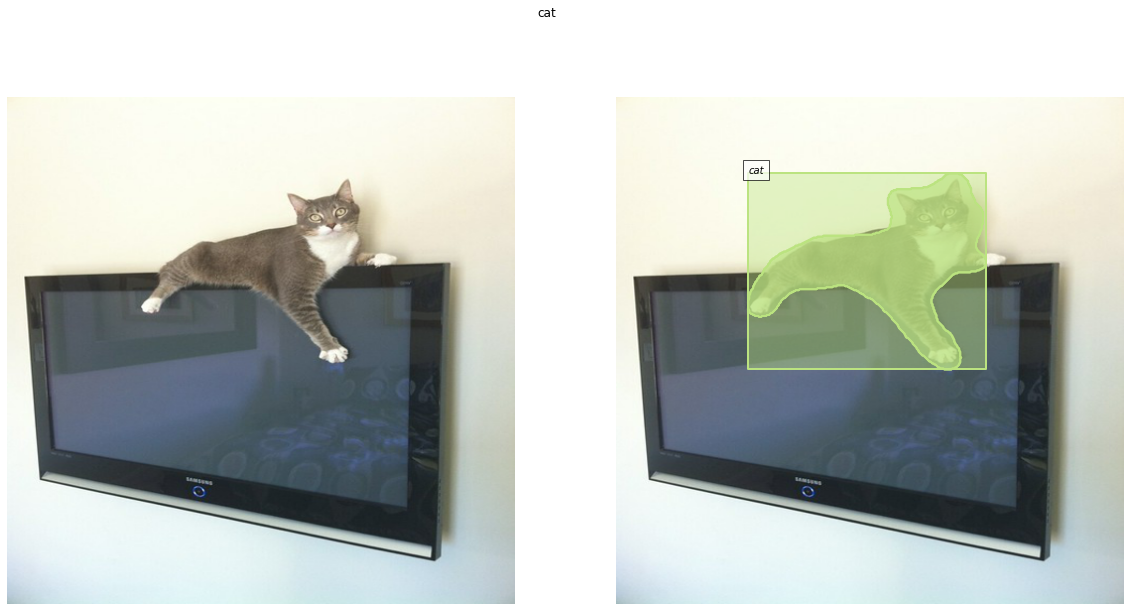

In [ ]:
for i in range(1, 2): # prompt: "Cat" On original image
  try:
    visualize_annotation(i)
  except Exception as e:
    print(f'Skipping {i}th visualization...')

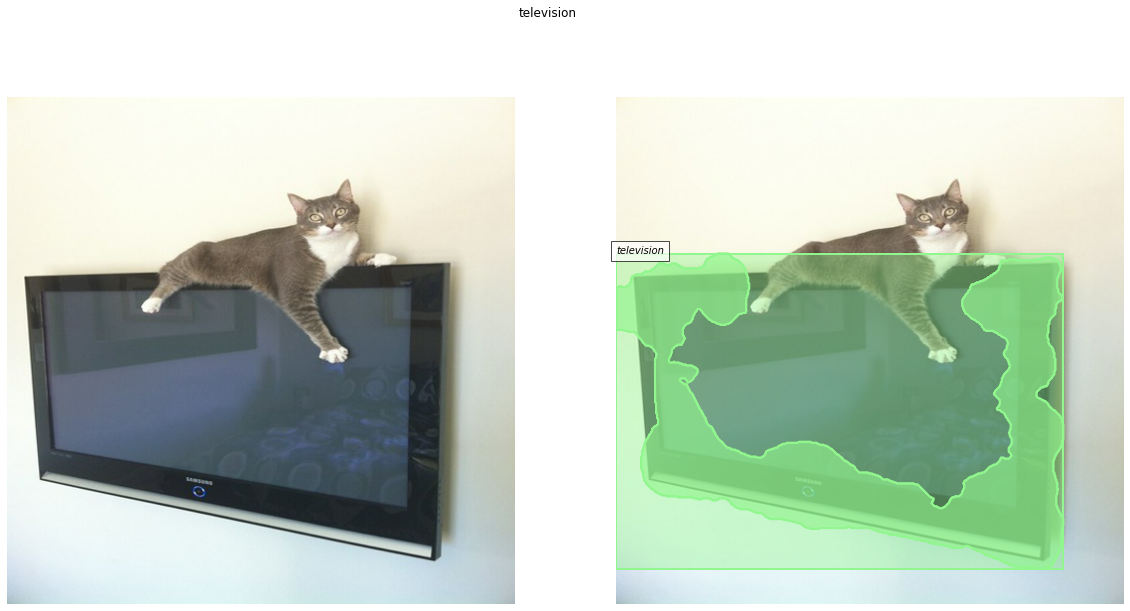

In [ ]:
for i in range(1, 2): # prompt: "Television" On original image
  try:
    visualize_annotation(i)
  except Exception as e:
    print(f'Skipping {i}th visualization...')

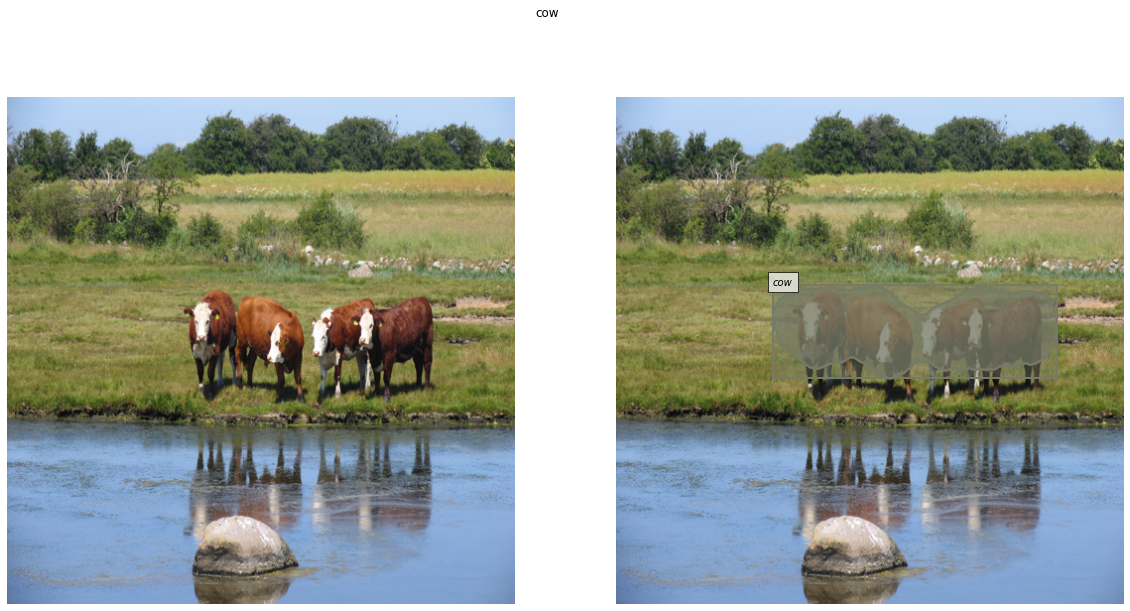

In [ ]:
for i in range(1, 2): # prompt: "Cow" on original image
  try:
    visualize_annotation(i)
  except Exception as e:
    print(f'Skipping {i}th visualization...')

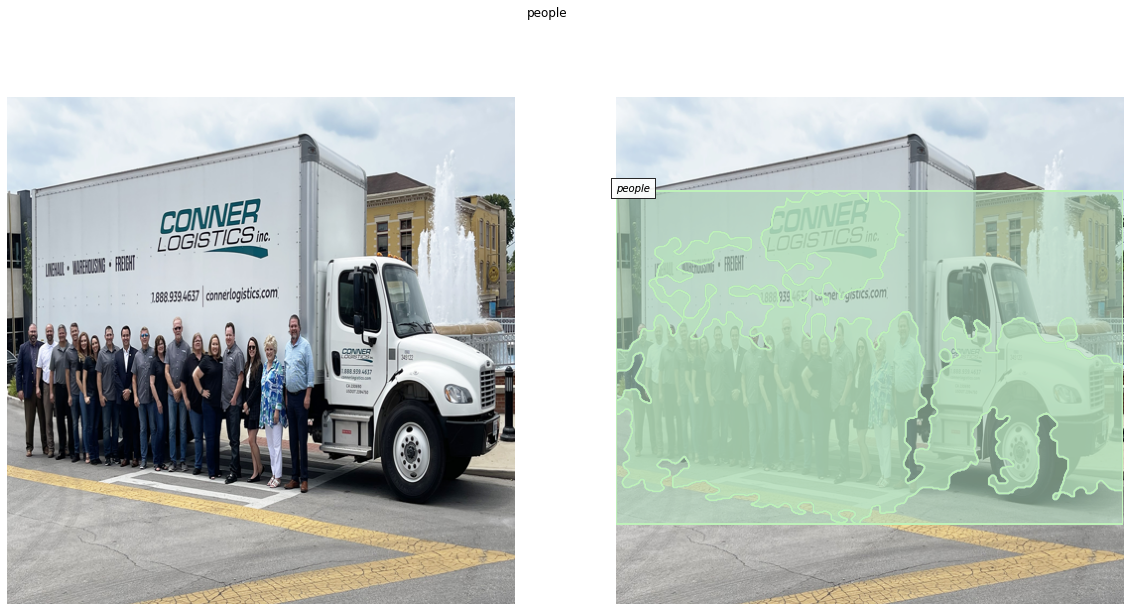

In [ ]:
for i in range(1, 2): # prompt: "Truck" on original image
  try:
    visualize_annotation(i)
  except Exception as e:
    print(f'Skipping {i}th visualization...')

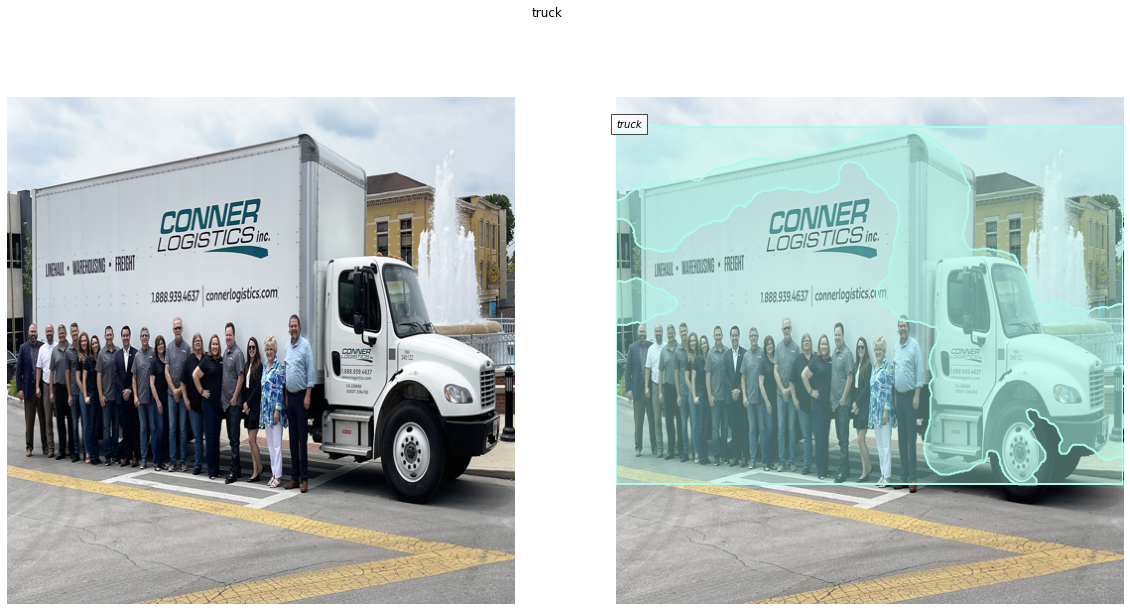

In [70]:
for i in range(1, 2): # prompt: "Truck" on original image
  try:
    visualize_annotation(i)
  except Exception as e:
    print(f'Skipping {i}th visualization...')

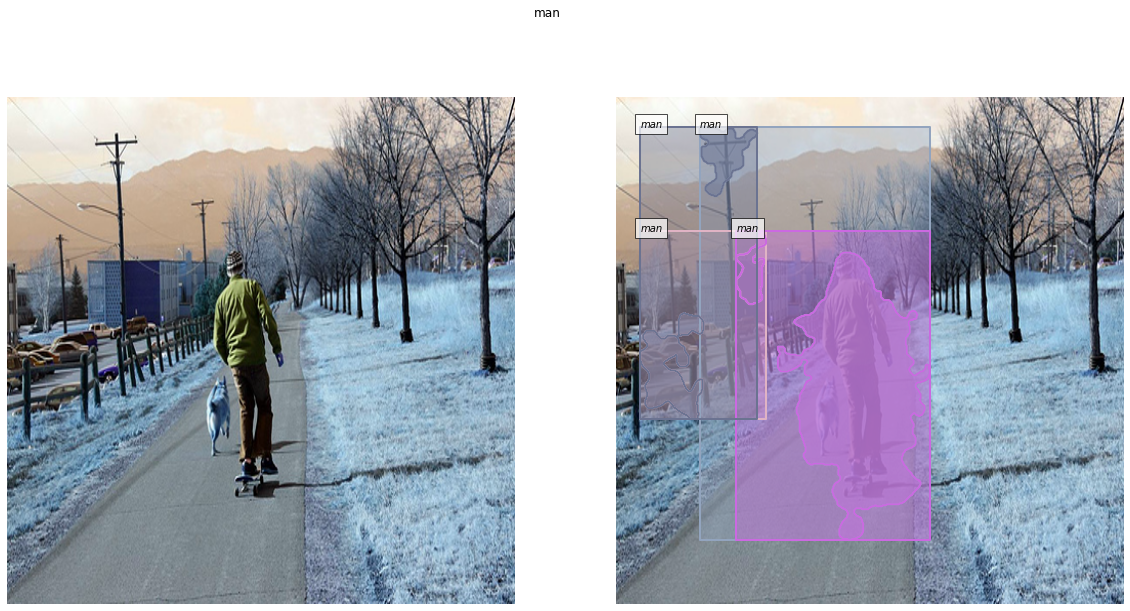

In [177]:
for i in range(1, 2): # prompt: "Man" on original image
  try:
    visualize_annotation(i)
  except Exception as e:
    print(f'Skipping {i}th visualization...')

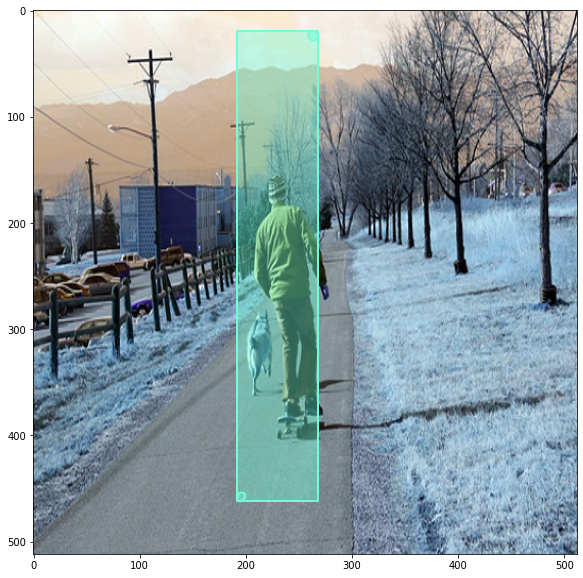

In [104]:
plt.figure(figsize=(20, 10))
plt.imshow(init_img)
coco_annotation.showAnns(coco_annotation.loadAnns(3), draw_bbox=True)

In [99]:
picks2idx

{93: [0, 93],
 92: [1, 2, 3, 4, 89, 90, 91, 92],
 7: [86, 7],
 69: [20, 69, 22],
 55: [35, 55],
 54: [64, 54, 30],
 36: [36, 70, 41, 74, 49, 19, 57, 27],
 46: [43, 45, 46],
 32: [32, 62],
 23: [75, 23],
 14: [5,
  6,
  8,
  9,
  10,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  21,
  24,
  25,
  26,
  28,
  29,
  31,
  33,
  34,
  37,
  38,
  39,
  40,
  42,
  44,
  47,
  48,
  50,
  51,
  52,
  53,
  56,
  58,
  59,
  60,
  61,
  63,
  65,
  66,
  67,
  68,
  71,
  72,
  73,
  76,
  77,
  78,
  79,
  80,
  82,
  83,
  84,
  85,
  87,
  88],
 11: [81, 11]}